In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
import folium

In [2]:
# upload data
card_info = pd.read_csv('cc_info.csv')
transaction_info = pd.read_csv('transactions.csv')

In [3]:
card_info.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,1501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [4]:
transaction_info.head()

,credit_card,date,transaction_dollar_amount,Long,Lat
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719


In [5]:
#check for missing values of card
card_info.isnull().sum()

credit_card          0
city                 0
state                0
zipcode              0
credit_card_limit    0
dtype: int64

In [6]:
#check for missing values of transaction
transaction_info.isnull().sum()

credit_card                  0
date                         0
transaction_dollar_amount    0
Long                         0
Lat                          0
dtype: int64

In [7]:
# #merge card and transaction both datadataframes into one dataframe
df = transaction_info.merge(card_info, on = 'credit_card')

In [23]:
df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,city,state,zipcode,credit_card_limit
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,Houston,PA,15342,20000
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,Houston,PA,15342,20000
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,Houston,PA,15342,20000
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,Houston,PA,15342,20000
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,Houston,PA,15342,20000


In [8]:
df.shape

(294588, 9)

<Axes: xlabel='state'>

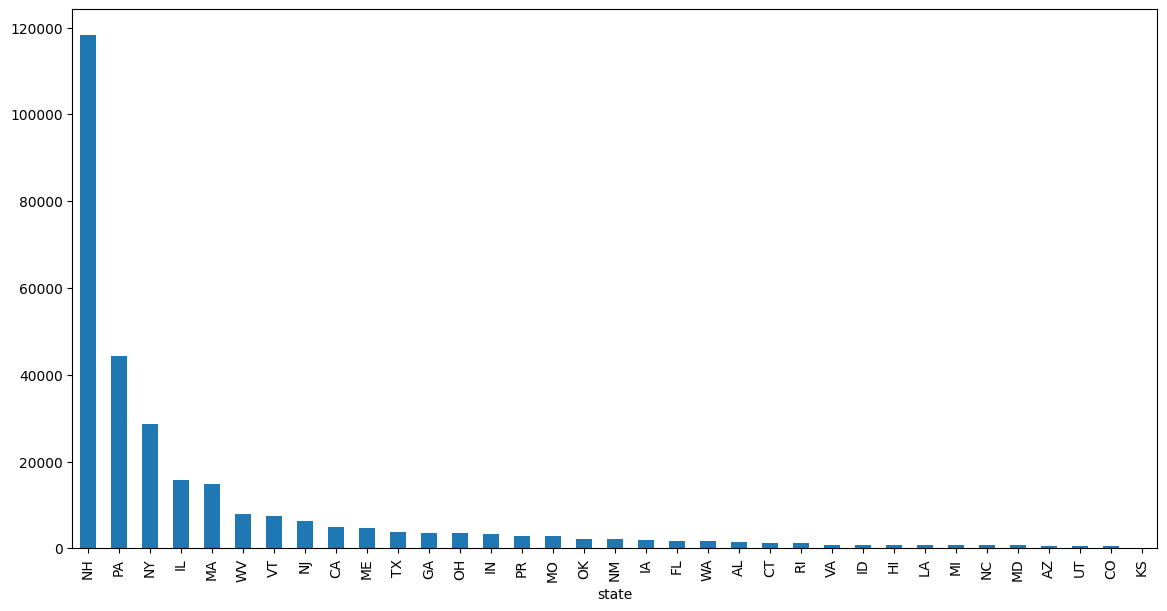

In [12]:
# Number of Transaction records state wise
df['state'].value_counts().plot(kind='bar', figsize = (14,7))


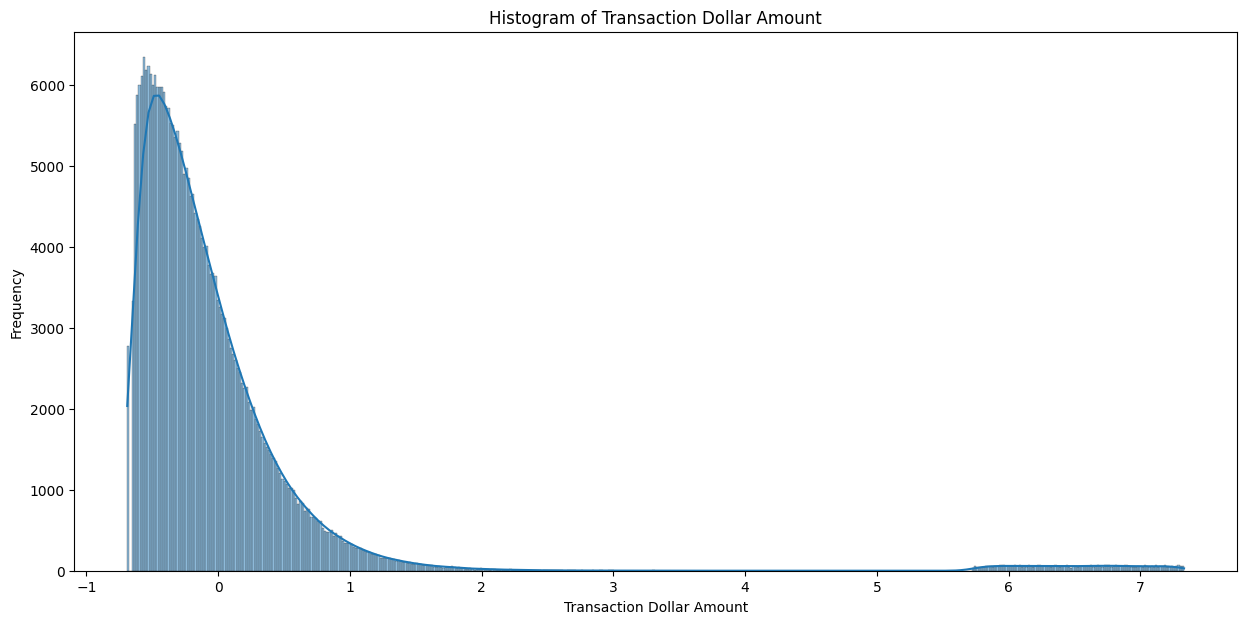

In [13]:
# Histogram of 'transaction_dollar_amount'

plt.figure(figsize=(15, 7))
sns.histplot(df['transaction_dollar_amount'], kde=True)
plt.title('Histogram of Transaction Dollar Amount')
plt.xlabel('Transaction Dollar Amount')
plt.ylabel('Frequency')
plt.show()

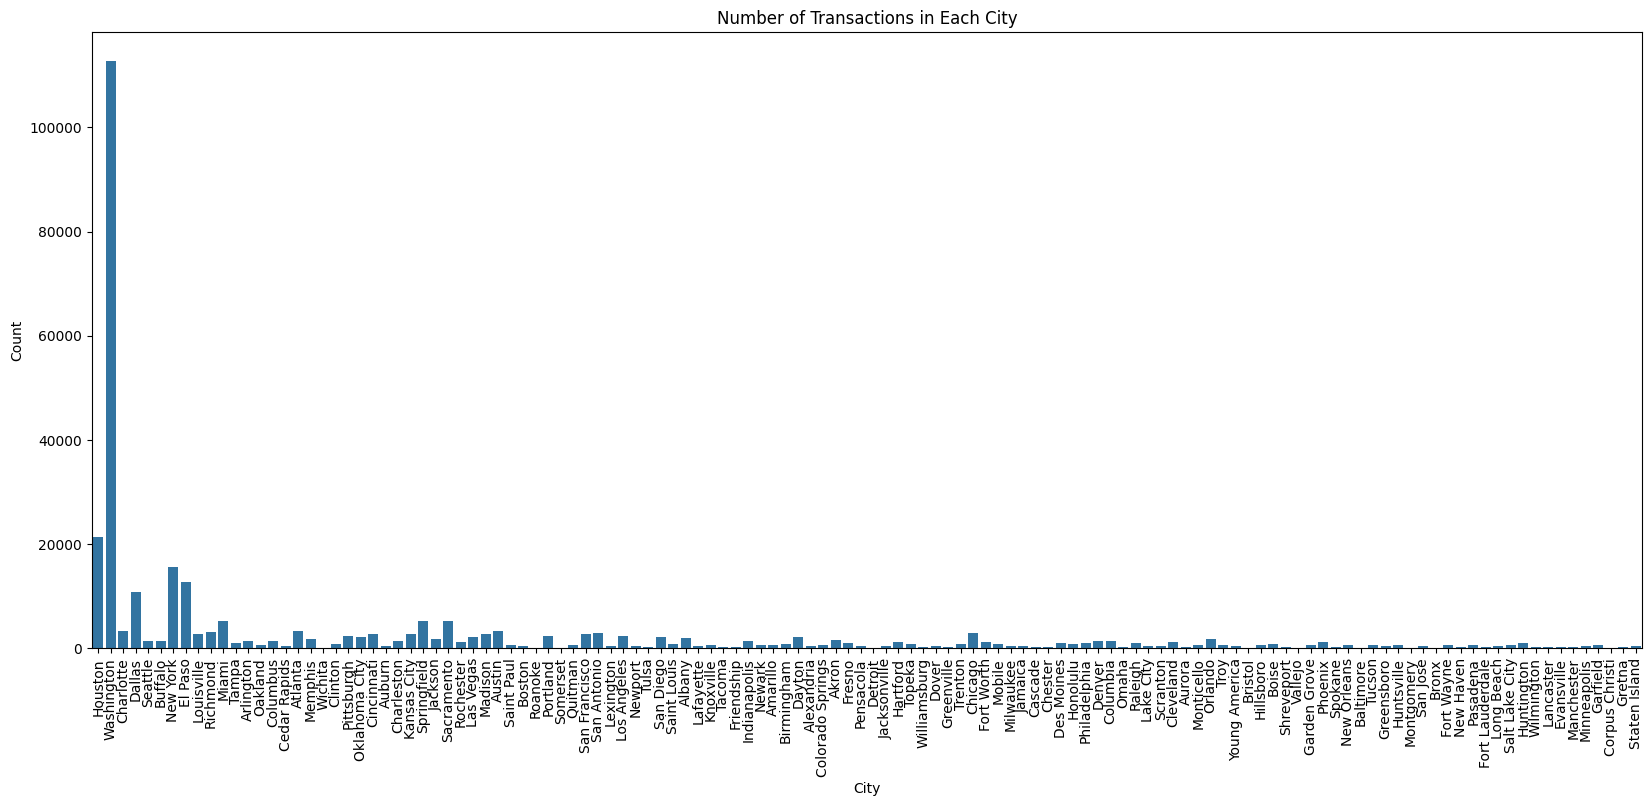

In [14]:
#Bar chart of the count of transactions in each city
plt.figure(figsize=(20, 8))
sns.countplot(data=df, x='city')
plt.title('Number of Transactions in Each City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.show()

In [20]:
# Building Fraud Detection Model

class FraudDetectionModel:
    def __init__(self, df):
        self.df = df
        self.feature_columns = ['transaction_dollar_amount', 'Long', 'Lat', 'credit_card_limit']
        self.model = None
        self.kmeans = None

    def data_preprocessing(self):
        scaler = StandardScaler()
        self.df[self.feature_columns] = scaler.fit_transform(self.df[self.feature_columns])

    def build_kmeans(self, n_clusters=2):
        self.kmeans = KMeans(n_clusters=n_clusters, random_state=42)

    def create_labels(self):
        if self.kmeans is None:
            raise ValueError("K-means model has not been built yet. Please call 'build_kmeans' first.")

        self.kmeans.fit(self.df[self.feature_columns])
        
        self.df['cluster_label'] = self.kmeans.predict(self.df[self.feature_columns])

        cluster_fraud_label = self.df.groupby('cluster_label')['transaction_dollar_amount'].mean().idxmax()
        self.df['is_fraudulent'] = self.df['cluster_label'].apply(lambda x: 1 if x == cluster_fraud_label else 0)


    def visualize_fraudulent_transactions(self):
        plt.figure(figsize=(15, 8))
        sns.scatterplot(data=df, x='credit_card_limit', y='transaction_dollar_amount', hue = 'is_fraudulent')
        plt.title('Credit Card Limit vs. Transaction Dollar Amount')
        plt.xlabel('Credit Card Limit')
        plt.ylabel('Transaction Dollar Amount')
        plt.show()

    def build_model(self):
        self.model = tf.keras.Sequential([
            tf.keras.layers.Dense(64, activation='relu', input_shape=(len(self.feature_columns),)),
            tf.keras.layers.Dense(32, activation='relu'),
            tf.keras.layers.Dense(1, activation='sigmoid')
        ])
        self.model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    def train_model(self, X_train, y_train, epochs=10, batch_size=32):
        self.model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, verbose=0)

    def evaluate_model(self, X_test, y_test):
        loss, accuracy = self.model.evaluate(X_test, y_test)

        y_pred = (self.model.predict(X_test) > 0.5).astype(int).flatten()
        print("Classification Report:")
        print(classification_report(y_test, y_pred))
        print("Confusion Matrix:")
        print(confusion_matrix(y_test, y_pred))

c:\Users\Viper\AppData\Local\Programs\Python\Python312\Lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


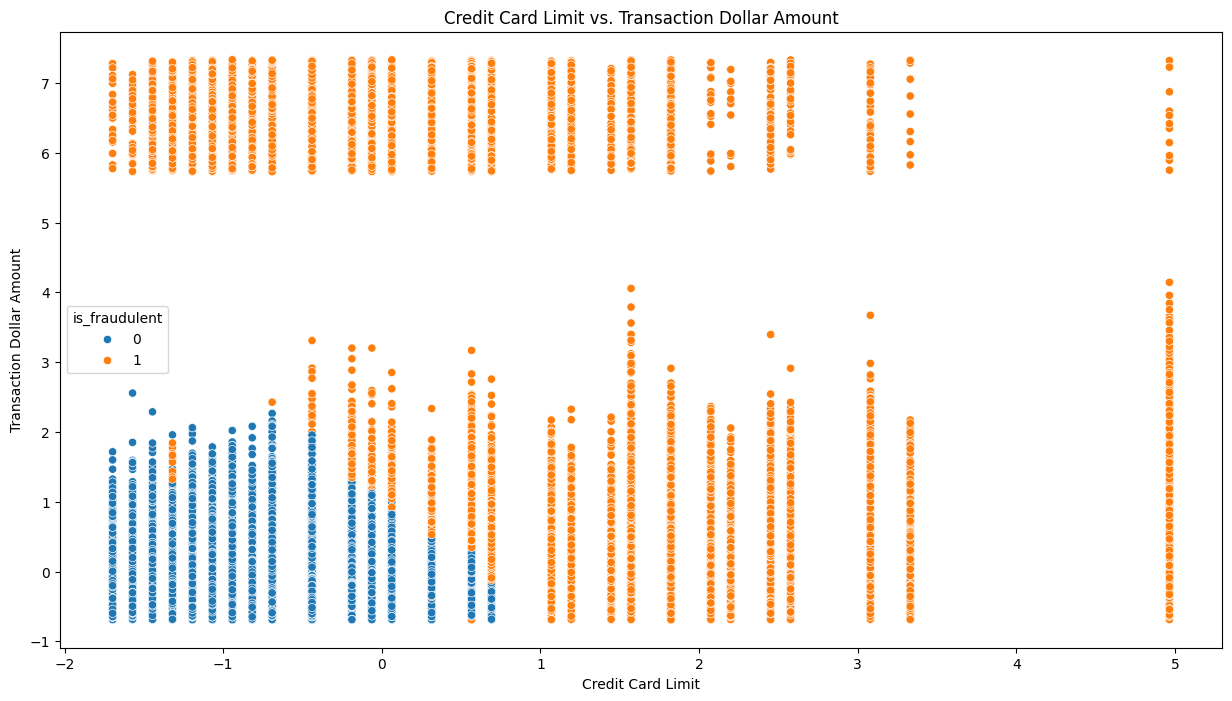

c:\Users\Viper\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model Training Complete.
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9990 - loss: 0.0024
1842/1842 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     44739
           1       1.00      1.00      1.00     14179

    accuracy                           1.00     58918
   macro avg       1.00      1.00      1.00     58918
weighted avg       1.00      1.00      1.00     58918

Confusion Matrix:
[[44699    40]
 [   29 14150]]


In [10]:
if __name__ == "__main__":
 
    model = FraudDetectionModel(df)
    model.data_preprocessing()
    model.build_kmeans()
    model.create_labels()

    model.visualize_fraudulent_transactions()

    X = model.df[model.feature_columns].values
    y = model.df['is_fraudulent'].values

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    model.build_model()
    model.train_model(X_train, y_train, epochs=10, batch_size=32)

    print("Model Training Complete.")

    model.evaluate_model(X_test, y_test)

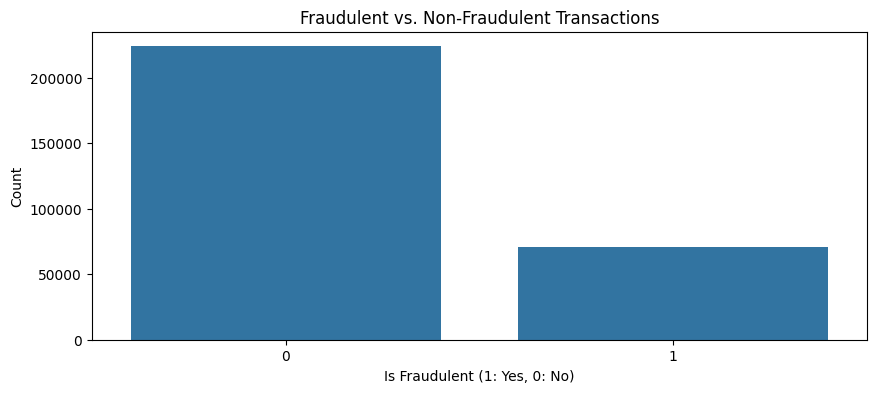

In [36]:
plt.figure(figsize=(10, 4))
sns.countplot(data=df, x='is_fraudulent')
plt.title('Fraudulent vs. Non-Fraudulent Transactions')
plt.xlabel('Is Fraudulent (1: Yes, 0: No)')
plt.ylabel('Count')
plt.show()

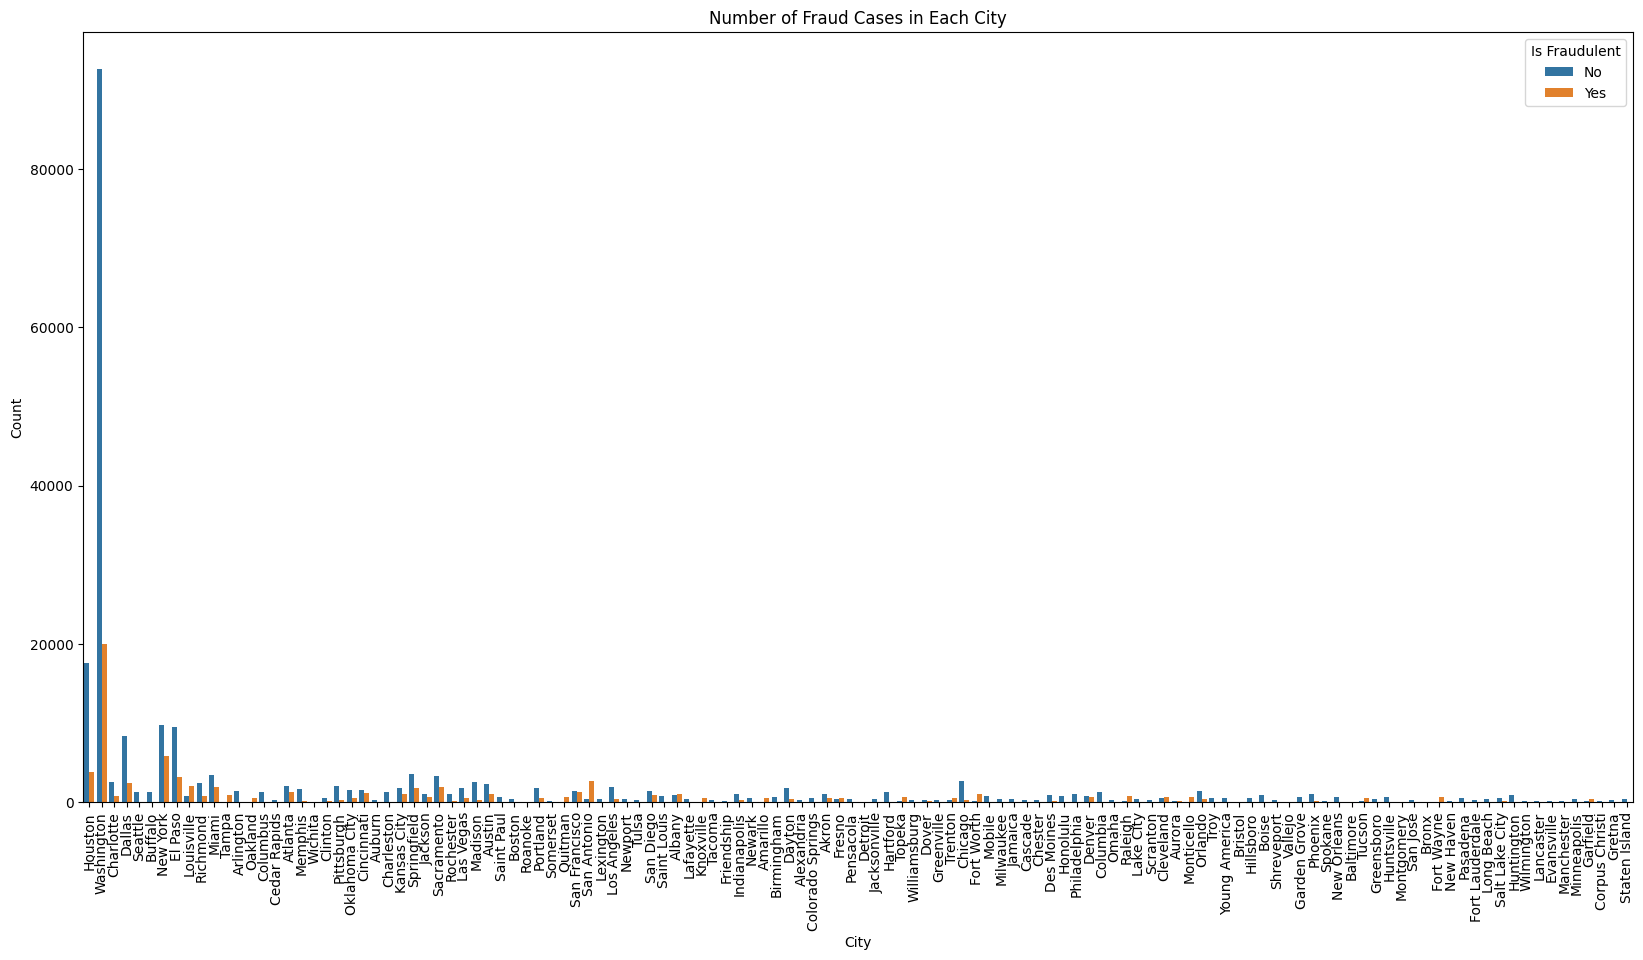

In [17]:
# Number of Fraud Cases in Each City

plt.figure(figsize=(20, 10))
sns.countplot(data=df, x='city', hue='is_fraudulent')
plt.title('Number of Fraud Cases in Each City')
plt.xlabel('City')
plt.ylabel('Count')
plt.xticks(rotation=90)
plt.legend(title='Is Fraudulent', labels=['No', 'Yes'])
plt.show()